<a href="https://colab.research.google.com/github/columbia-data-club/meetings/blob/main/2023/april_6_optimal_lda_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df = pd.read_parquet("https://github.com/columbia-data-club/meetings/blob/main/assets/data/mar_10_articles_full.parquet?raw=true",
                     columns=["url", "headline",	"hostname",	"raw_html_text"])

In [2]:
from bs4 import BeautifulSoup
from datetime import datetime
import numpy as np

def extract_textual_features(raw_html_text):
  html = BeautifulSoup(raw_html_text, "html.parser")
  provider = html.find("span", class_="caas-attr-provider").text.strip()
  publication_datetime = datetime.strptime(html.find("time").get("datetime"), "%Y-%m-%dT%H:%M:%S.%f%z")
  byline = html.find("div", class_="caas-attr-item-author").text.strip()
  read_time = np.nan
  read_time_span = html.find("span", class_="caas-attr-mins-read")
  if read_time_span:
    read_time = int(read_time_span.text.strip().replace(" min read", ""), base=10)
  text = " ".join([p.text.strip() for p in html.find("div", class_="caas-body").find_all("p")])
  char_count = len(text)

  return [provider, publication_datetime, byline, read_time, char_count, text]

In [3]:
from tqdm.auto import tqdm

tqdm.pandas()

# ~1:13 to complete
df[["provider", "publication_datetime", "byline", "read_time", "char_count", "text"]] = df.progress_apply(
    lambda row: extract_textual_features(row["raw_html_text"]),
    axis=1,
    result_type="expand")

  0%|          | 0/2504 [00:00<?, ?it/s]

In [6]:
import re
import nltk
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
gensim_docs = [[w for w in re.findall(r'\b\w\w+\b', paragraph.lower()) if w not in stopwords] for paragraph in df["text"]]
dict_gensim_docs = Dictionary(gensim_docs)
dict_gensim_docs.filter_extremes(no_below=5, no_above=0.7)
bow_gensim_docs = [dict_gensim_docs.doc2bow(doc) for doc in gensim_docs]
tfidf_gensim_docs = TfidfModel(bow_gensim_docs)
vectors_gensim_docs = tfidf_gensim_docs[bow_gensim_docs]

In [8]:
lda_docs_model_n = []
for n in tqdm(range(5, 21)):
  lda_model = LdaMulticore(corpus=bow_gensim_docs,
    id2word=dict_gensim_docs,
    chunksize=2000, eta="auto", iterations=400,
    num_topics=n, passes=20, eval_every=None,
    random_state=42)
  lda_coherence = CoherenceModel(model=lda_model, texts=gensim_docs,
    dictionary=dict_gensim_docs, coherence="c_v")
  lda_docs_model_n.append((n, lda_model, lda_coherence.get_coherence()))

  0%|          | 0/16 [00:00<?, ?it/s]

<Axes: xlabel='n'>

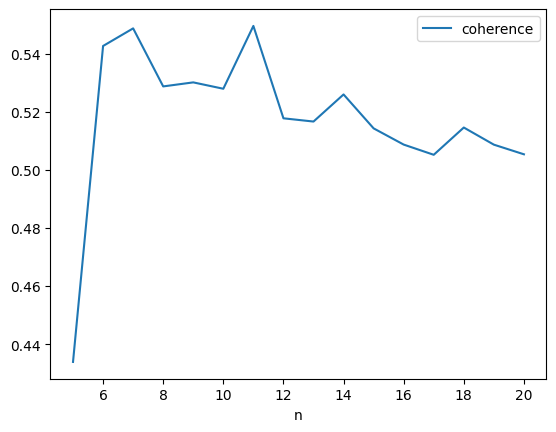

In [9]:
pd.DataFrame(lda_docs_model_n, 
  columns=["n", "model", "coherence"]).set_index("n")[["coherence"]].plot()